# Bag of Visual Words Image Classification: Week 1
## Team 4: 
- Òscar Lorente Corominas
- Ian Riera Smolinska
- Aditya Sangram Singh Rana

## Table of contents
* [1. Dataset](#dataset) 
* [2. Keypoints and descriptors](#keypoints_and_descriptors)
    * [2.1 Vanilla SIFT and SURF](#vanilla)
    * [2.2 Dense Descriptors (SIFT, SURF and DAISY)](#dense)
* [3. Spatial pyramids](#spatial_pyramids)
* [4. Clustering](#clustering)
* [5. Classifiers](#classifiers)
    * [5.1 K-NN classifier](#knn)
    * [5.2 Logistic Regression](#logreg)
* [6. Reducing dimensionality](#pca)
* [7. Cross-validation](#cross_validation)
* [8. Test validation](#test_validation)
* [9. Results visualization](#visualization)
    * [9.1 ROC curve](#roc_curve)

First step is to install the required libraries.

In [6]:
!pip install opencv-contrib-python==3.4.2.17
!pip install scikit-image
!pip install pandas
!pip install requests
!pip install seaborn

We have to import the libraries that we will be using in the notebook.

In [7]:
import cv2
import numpy as np
import pickle as cPickle
from sklearn.cluster import MiniBatchKMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from sklearn.model_selection import cross_validate
from sklearn.metrics import *
from sklearn.preprocessing import LabelBinarizer

from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from itertools import cycle

from sklearn.linear_model import LogisticRegression
# grid search part
from sklearn.model_selection import GridSearchCV
import pandas as pd # library for data analsysis
import requests # library to handle requests

from PIL import Image

from skimage.feature import daisy
import matplotlib.pyplot as plt

import seaborn as sns

## 1. Dataset <a name="dataset"></a>

Let us first read the train and test files

In [8]:
train_images_filenames = cPickle.load(open('train_images_filenames.dat','rb'))
test_images_filenames = cPickle.load(open('test_images_filenames.dat','rb'))
train_labels = cPickle.load(open('train_labels.dat','rb'))
test_labels = cPickle.load(open('test_labels.dat','rb'))

Let's write a simple script to visualize the dataset

In [9]:
def visualize_dataset(image_filenames, labels, samples_per_class=5):
    """
    Visualize the dataset
    """
    print(f'Number of samples: {len(image_filenames)}')
    # get unique classses
    classes = np.unique(np.array(labels))
    num_classes = len(classes)
    #set size for plot
    plt.figure(figsize=(15,8))
    
    for y, cls in enumerate(classes):
        _idxs = np.flatnonzero(np.array(labels) == cls)
        idxs = np.random.choice(_idxs, samples_per_class, replace=False)
        for i, idx in enumerate(idxs):
            plt_idx = i * num_classes + y + 1
            plt.subplot(samples_per_class, num_classes, plt_idx)
            plt.imshow(Image.open(image_filenames[idx]))
            plt.axis('off')
            if i == 0:
                plt.title(f'{cls} ({len(_idxs)})')
    plt.show()

Number of samples: 1881


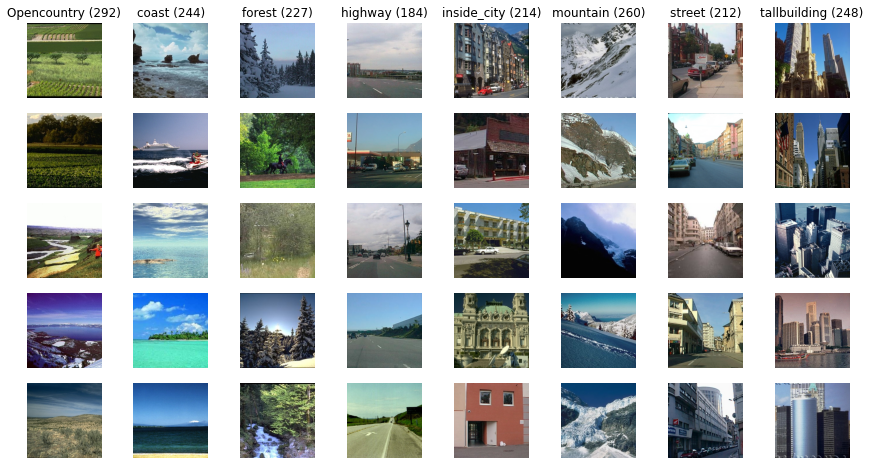

In [10]:
#for the training dataset
visualize_dataset(train_images_filenames, train_labels, samples_per_class=5)

Number of samples: 807


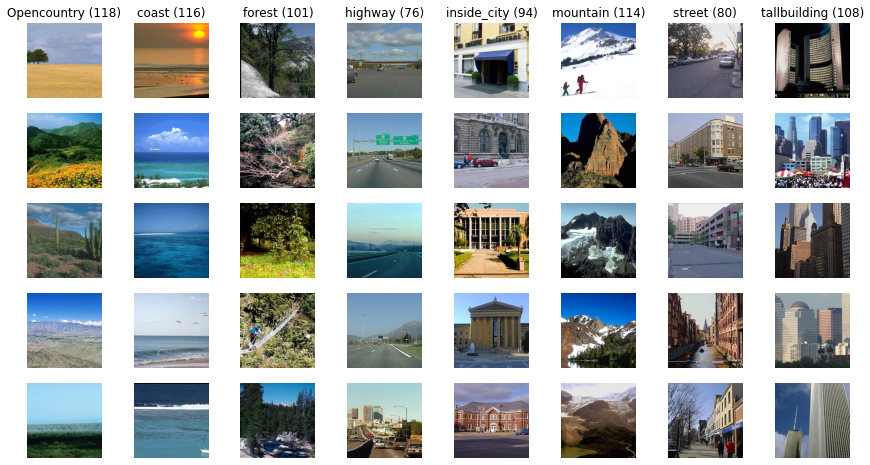

In [11]:
#for the testing dataset
visualize_dataset(test_images_filenames, test_labels, samples_per_class=5)

## 2. Keypoints and Descriptors <a name="keypoints_and_descriptors"></a>
The following descriptors were tested:

1. SIFT (vanilla and dense)
2. SURF (vanilla and dense)
3. DAISY (only dense)

We also considered using ORB, AKAZE and FREAK, however these algorithms use binary descriptors by default. 

### 2.1 Vanilla SIFT and SURF <a name="vanilla"></a>

Let's start by visualizing some keypoints

In [12]:
def show_keypoints(img_path, descriptor=None, kps=None):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

    if kps is None:
        kp = descriptor.detect(gray)
    else:
        kp = kps

    kp_img = cv2.drawKeypoints(img, kp, gray)
    fig,axes = plt.subplots(1,2, figsize=(8,4))
    titles = ['Original_image',f'Keypoints:{len(kp)}']
    images = [img, kp_img]
    for ax, image, title in zip(axes.flatten(), images, titles):
        ax.imshow(image)
        ax.set_title(title)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

In [13]:
# let's sample an image
sample = train_images_filenames[15]

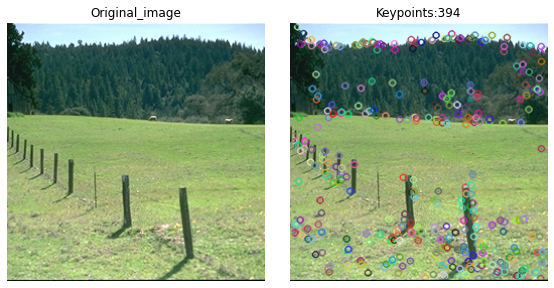

In [14]:
sift = cv2.xfeatures2d.SIFT_create()
show_keypoints(sample,sift)

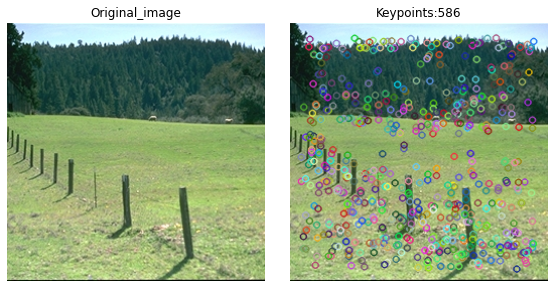

In [15]:
surf = cv2.xfeatures2d.SURF_create()
show_keypoints(sample,surf)

#### Generate Descriptors

To detect keypoints and compute descriptors using SIFT and SURF.

In [16]:
img = cv2.imread(sample)
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

# SIFT
SIFTdetector = cv2.xfeatures2d.SIFT_create(nfeatures=300)
_, sift_descriptor = SIFTdetector.detectAndCompute(gray, None)

# SURF
SURFdetector = cv2.xfeatures2d.SURF_create(hessianThreshold=600)
_, surf_descriptor = SURFdetector.detectAndCompute(gray, None)

#### Tuning SIFT and SURF parameters
First of all, we compute the accuracy and average precision, recall and f1-score with 8 (stratified) fold cross-validation to tune the following parameters:
- nfeatures of SIFT
- hessianThreshold of SURF

In these cases, we consider the codebook size = 128 and we use KNN-Classifier with K=5 and euclidean distance.

NOTE: The scripts we used for gridsearch are provided along with the notebook in the folder 'gridsearch'. 
Moreover, we use the following function 'plot_metrics' to visualize the results.

In [17]:
def plot_metrics(pd_data, param):
    """
    Utility function to plot accuracy, precision, recall and f1-score
    """
    fig,axes = plt.subplots(2,2, figsize=(8,8), sharex=True)
    titles = ['Cross-val accuracy', 'Cross-val precision', 'Cross-val recall', 'Cross-val f1']
    ylabels = ['Accuracy', 'Precision', 'Recall', 'F1-score']
    ymax = pd_data[titles].max().max()
    ymin = pd_data[titles].min().min()
    for ax, title, ylabel in zip(axes.flatten(), titles, ylabels):
        ax.grid(True)
        ax.scatter(pd_data[param], pd_data[title])
        ax.set(xlabel=param, ylabel=ylabel, ylim=(ymin*0.99, ymax*1.01))
        ax.set_title(title)
    plt.tight_layout()
    plt.show()

#### SIFT: Finding the best nfeatures

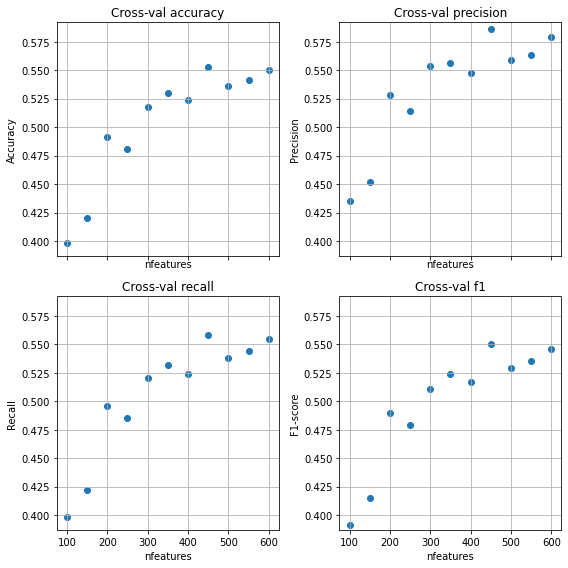

In [18]:
sift_gridsearch = pd.read_csv('../../Optimize_params/single_params/sift_nfeatures.csv')
plot_metrics(sift_gridsearch, 'nfeatures')

#### SURF: Finding the best hessianThreshold

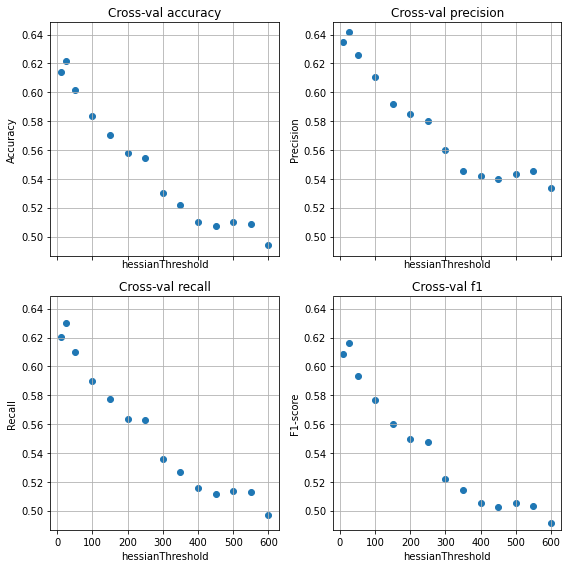

In [19]:
surf_gridsearch = pd.read_csv('../../Optimize_params/single_params/surf_hessianthr.csv')
plot_metrics(surf_gridsearch, 'hessianThreshold')           

#### Conclusions

- For SIFT, the performance of the model increases with the number of features upto a certain point, 
after which it begins to decrease. The bigger number of features of the image, the more representative are the 
descriptors, so the classification performance is better. However, too many features will worsen the performance,
as not all features from an image are relevant for classification.
- For SURF, the threshold determines how large the output from the Hessian filter must be in order for a point to be 
used as an interest point. For this reason, a larger value will result in fewer keypoints, so the classification 
performance will be worse.

We obtain the best results for SIFT with nfeatures = 450, and for SURF with hessianThreshold = 25


### 2.2 Dense Descriptors (SIFT, SURF and DAISY) <a name="dense"></a>
 
To implement Dense SIFT and SURF, we create a grid of spatially equidistant keypoints. 
The distance between each keypoint is configured with the "step size" parameter.

In addition, the Daisy dense descriptor is computed as well.

In [20]:
# To create dense keypoints
def create_dense_kp(img_shape, step_size):
    return [cv2.KeyPoint(x, y, step_size) for y in range(0, img_shape[0], step_size) 
                                          for x in range(0, img_shape[1], step_size)]

# Dense SIFT and SURF
img=cv2.imread(sample)
gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

dense_kp = create_dense_kp(gray.shape, step_size=10)                              
_,dense_sift_des = SIFTdetector.compute(gray, dense_kp)
_,dense_surf_des = SURFdetector.compute(gray, dense_kp)

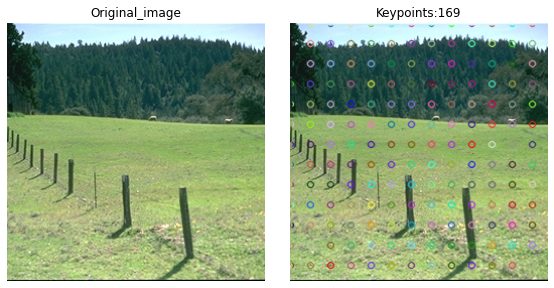

In [21]:
# Show dense keypoints (each 20 pixels)
dense_kp = create_dense_kp(gray.shape, step_size=20)
show_keypoints(sample, kps=dense_kp)

For DAISY, we can visualize the descriptors as well.

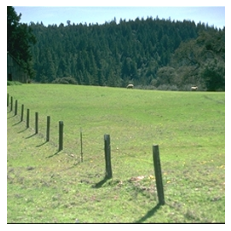

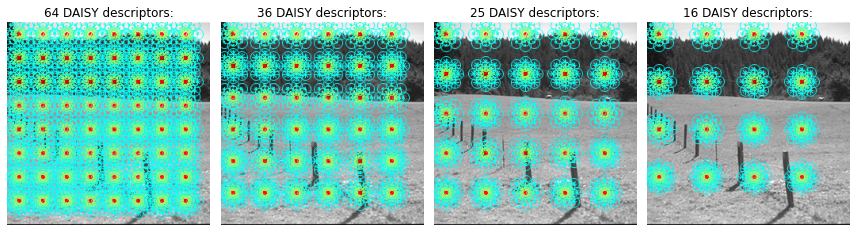

In [22]:
# demo
plt.imshow(Image.open(sample))
plt.axis('off')
plt.show()

img=cv2.imread(sample)
gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

fig,axes = plt.subplots(1,4, figsize=(12,8))
steps = [30,40,50,60]
for ax,step in zip(axes.flatten(),steps):
    des, des_img = daisy(gray, step=step, visualize=True)
    des = des.reshape(-1,des.shape[2])
    ax.imshow(des_img)
    ax.set_title('%i DAISY descriptors:' % des.shape[0])
    ax.axis('off')
plt.tight_layout()
plt.show()

#### Tuning Dense descriptors parameters
We compute the accuracy and average precision, recall and f1-score with 8 (stratified) fold cross-validation to tune the parameter "Step size" of Dense SIFT and SURF, and DAISY.

We're also using codebook size = 128 , KNN-Classifier with K=5, euclidean distance.

#### Dense SIFT: Finding the best Step size

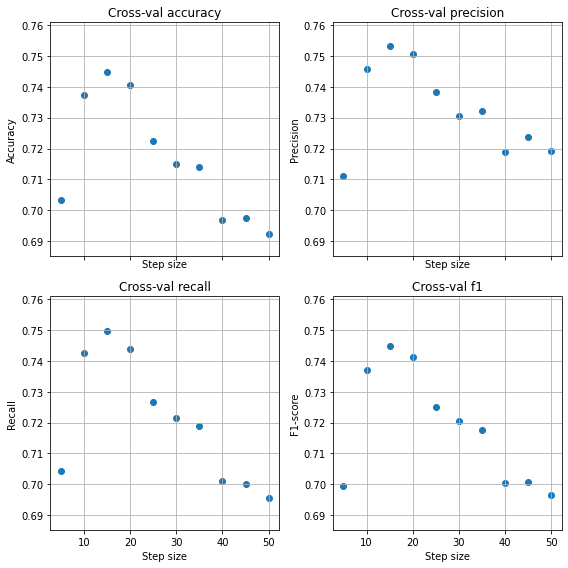

In [23]:
dense_sift_gridsearch = pd.read_csv('../../Optimize_params/single_params/dense_sift_step.csv')
plot_metrics(dense_sift_gridsearch, 'Step size')

#### Dense SURF: Finding the best Step size

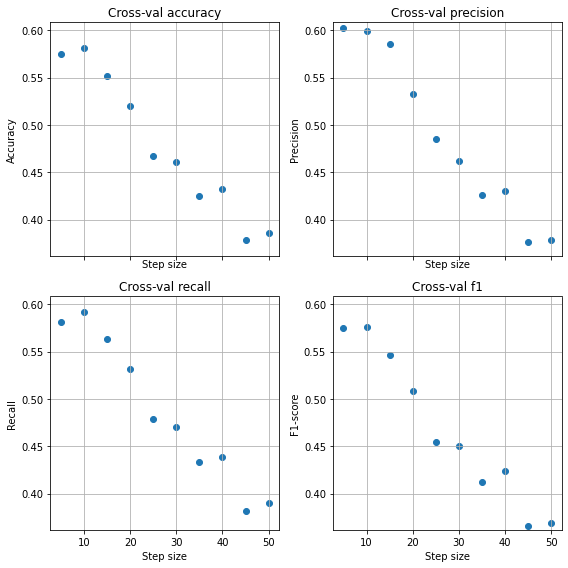

In [24]:
dense_surf_gridsearch = pd.read_csv('../../Optimize_params/single_params/dense_surf_step.csv')
plot_metrics(dense_surf_gridsearch, 'Step size')

#### DAISY: Finding the best Step size

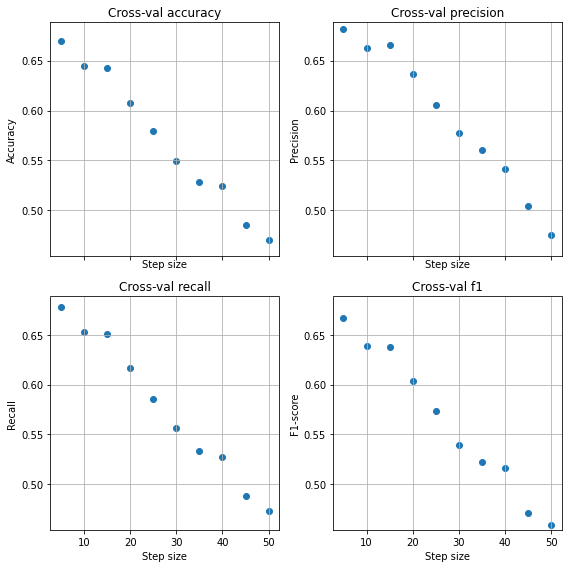

In [25]:
daisy_gridsearch = pd.read_csv('../../Optimize_params/single_params/daisy_step.csv')
plot_metrics(daisy_gridsearch, 'Step size')

#### Conclusions
- The dense decriptors outperform (vanilla) SIFT and SURF. The main reason is that vanilla SIFT and SURF depend on the
performance of the keypoint detector, so if the detection is poor, the classification will be bad as well. When using
dense keypoints, we get a representative descriptor of the images even if the content of the image is plain (low textures)
or has repetitive patterns. 
- In all cases, with a smaller step size we're using more keypoints and therefore the resulting feature descriptor is more representative,
so the classifier performance is better, but at the same time the computational cost increases exponentially.
- Using DAISY, we obtain the best results with the smallest step size (5), so it would probably increase with even smaller values.
However, the computational cost is too expensive to execute it. In a more exhaustive optimization of the descriptor, we could
have decreased other parameter values (e.g. codebook size to 32) to test DAISY with smaller step sizes, 
but as dense SIFT results are far better, we discarded that option.

We obtain the best results for Dense SIFT with step size = 15, for Dense SURF with step size = 10 and for DAISY with step size = 5.

## 3. Spatial Pyramids <a name="spatial_pyramids"></a>

The Bag of Visual Words efficiently aggregates local features into a single global vector but it completely ignores the information about 
the spatial layout of the features.

To tackle this, we compute the keypoints and descriptors at different pyramidal levels. Spatial pyramids work by partitioning the image 
into increasingly fine sub-regions and computing histograms of the codewords inside each sub-region.

In level:
- 0: we compute descriptors of the whole image
- 1: we divide the image in 4 blocks and compute the descriptors for each of them, and finally concatenate them with the whole image descriptor
- 2: we divide the image in 16 blocks, ...
- ...

By computing the descriptors of the different sub-regions of the image, we can later compute the histograms of 
visual words of each of the regions. The code to compute these spatial pyramid histograms is presented in Section [4. Clustering](#clustering).

In [26]:
# for sift and surf
def spatial_pyramid(img, descriptor, level=1, dense=False, step_size=15):
    if dense:
        dense_kp = create_dense_kp(img.shape, step_size=step_size)
        _,des = descriptor.compute(img, dense_kp)

    else:
        _,des=descriptor.detectAndCompute(img,None)

    # list that contains the descriptors of img at different levels,
    # being pyramid_descriptors[0] the descriptors of the whole image
    pyramid_descriptors = [des]

    # pyramid_descriptors[1:4] -> descriptors of the four cells (of size 1/4 of the image size)
    # ...

    for l in range(1,level+1):
        level_factor = 2*l
        cell_h = int(gray.shape[0]/level_factor)
        cell_w = int(gray.shape[1]/level_factor)
        
        if dense:
            dense_kp_cell = create_dense_kp([cell_h,cell_w], step_size=step_size)
            
        for f_h in range(level_factor):
            shift_h = f_h*cell_h
            for f_w in range(level_factor):
                shift_w = f_w*cell_w
                cell = img[shift_h:shift_h+cell_h, shift_w:shift_w+cell_w]

                if dense:
                    _,des = descriptor.compute(cell, dense_kp_cell)
                else:
                    _,des = descriptor.detectAndCompute(cell, None)

                pyramid_descriptors.append(des)
    return pyramid_descriptors

In [27]:
# for daisy
def spatial_pyramid_daisy(img, step=30, level=1):
    des = daisy(img, step=step)
    des = des.reshape(-1,des.shape[2])

    # list that contains the descriptors of img at different levels
    pyramid_descriptors = [des]

    for l in range(1,level+1):
        level_factor = 2*l
        cell_h = int(gray.shape[0]/level_factor)
        cell_w = int(gray.shape[1]/level_factor)

        for f_h in range(level_factor):
            shift_h = f_h*cell_h
            for f_w in range(level_factor):
                shift_w = f_w*cell_w
                cell = img[shift_h:shift_h+cell_h, shift_w:shift_w+cell_w]
                des = daisy(cell, step=step)
                des = des.reshape(-1,des.shape[2])
                pyramid_descriptors.append(des)
                
    return pyramid_descriptors

#### Tuning spatial pyramid level 

We compute the accuracy and average precision, recall and f1-score with 8 (stratified) fold cross-validation to tune the parameter "pyramid level".

We're also using codebook size = 128 , KNN-Classifier with K=5, euclidean distance.

In [28]:
# cross-val accuracy
pyramid_level_accuracy = pd.read_csv('../../Optimize_params/single_params/pyramid_level_accuracy.csv')
pyramid_level_accuracy.round(3)

Spatial pyramid level   SIFT   SURF  Dense SIFT  Dense SURF  DAISY
0                      0  0.533  0.622       0.745       0.551  0.644
1                      1  0.534  0.634       0.752       0.571  0.651
2                      2  0.502  0.621       0.759       0.564  0.640

In [29]:
# cross-val precision
pyramid_level_precision = pd.read_csv('../../Optimize_params/single_params/pyramid_level_precision.csv')
pyramid_level_precision.round(3)

Spatial pyramid level   SIFT   SURF  Dense SIFT  Dense SURF  DAISY
0                      0  0.586  0.544       0.753       0.600  0.663
1                      1  0.602  0.567       0.761       0.629  0.672
2                      2  0.605  0.537       0.768       0.633  0.662

In [30]:
# cross-val recall
pyramid_level_recall = pd.read_csv('../../Optimize_params/single_params/pyramid_level_recall.csv')
pyramid_level_recall.round(3)

Spatial pyramid level   SIFT   SURF  Dense SIFT  Dense SURF  DAISY
0                      0  0.559  0.513       0.750       0.592  0.652
1                      1  0.551  0.504       0.757       0.604  0.662
2                      2  0.528  0.469       0.764       0.594  0.652

In [31]:
# cross-val f1-score
pyramid_level_f1 = pd.read_csv('../../Optimize_params/single_params/pyramid_level_f1.csv')
pyramid_level_f1.round(3)

Spatial pyramid level   SIFT   SURF  Dense SIFT  Dense SURF  DAISY
0                      0  0.550  0.505       0.745       0.576  0.639
1                      1  0.549  0.497       0.752       0.591  0.648
2                      2  0.527  0.461       0.760       0.581  0.637

#### Conclusions

- Comparing all the descriptors with different pyramid levels, we observe that level 1 slightly outperforms level 0
in most of the cases, which proves that spatial information of features is relevant to image classification performance.

- On the other hand, we observe that level 2 and level 1 only differ by a small margin 
in most of the cases, but level 2 comes with a big extra computational cost (21 vs 5 histograms), so level 1 is chosen 
as the most suitable pyramidal level to use. For higher pyramidal levels, curse of dimensionality also comes into picture 
as our feature space becomes sparse.

##### From now on, we'll use Dense SIFT with step size = 15 and pyramid level = 1.

Now we can compute the training descriptors for our model using our best descriptor so far.

In [32]:
Train_descriptors = []
Train_label_per_descriptor = []

train_pyramid_descriptors = []

for filename,labels in zip(train_images_filenames,train_labels):
    ima=cv2.imread(filename)
    gray=cv2.cvtColor(ima,cv2.COLOR_BGR2GRAY)
    pyramid_des = spatial_pyramid(gray, SIFTdetector, level=1, dense=True, step_size=15)
    train_pyramid_descriptors.append(pyramid_des)
    Train_descriptors.append(pyramid_des[0])
    Train_label_per_descriptor.append(labels)

D=np.vstack(Train_descriptors)

## 4. Clustering <a name="clustering"></a>

We cluster the feature space using k-means, being k the codebook size (number of visual words).

In [34]:
k = 128
codebook = MiniBatchKMeans(n_clusters=k, verbose=False, batch_size=k * 20,compute_labels=False,reassignment_ratio=10**-4,random_state=42)
codebook.fit(D)

MiniBatchKMeans(batch_size=2560, compute_labels=False, init='k-means++',
                init_size=None, max_iter=100, max_no_improvement=10,
                n_clusters=128, n_init=3, random_state=42,
                reassignment_ratio=0.0001, tol=0.0, verbose=False)

We also tried to cluster the feature space using Gaussian Mixture Models (GMM). However, it was computationally
 too expensive, so we discarded it. We could have decreased other parameter values to reduce the dimensionality of the
 feature descriptors, but we thought this was not the scope of the project, as k-means is good (and fast!) enough for
 our purposes. 

````python
# Too expensive :(
from sklearn.mixture import GaussianMixture
k = 8
codebook = GaussianMixture(n_components=k, verbose=False, random_state=42)
codebook.fit(D)
````

#### Tuning codebook size (k)

We compute the accuracy and average precision, recall and f1-score with 8 (stratified) fold cross-validation to tune the parameter codebook size.

We're using KNN-Classifier with K=5, euclidean distance.

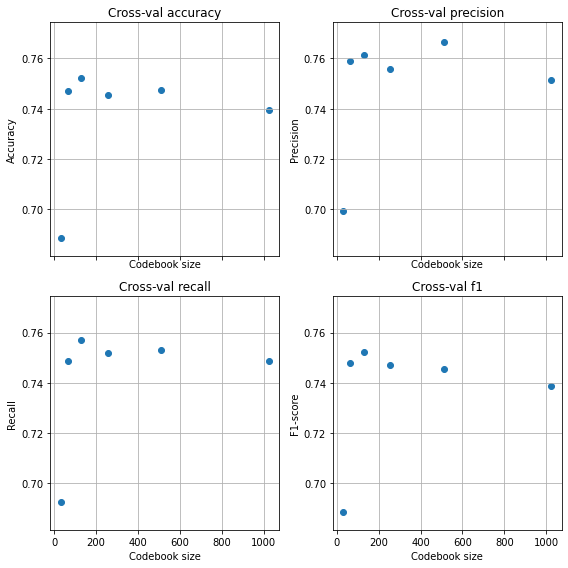

In [33]:
codebook_size_gridsearch = pd.read_csv('../../Optimize_params/single_params/codebook_size.csv')
plot_metrics(codebook_size_gridsearch, 'Codebook size')

Here, we compute the histograms of the sub-regions of the image using the descriptors explained in Section [3. Spatial Pyramids](#spatial_pyramids). For each train image, we project each keypoint descriptor to its closest visual word. We represent each of the images with the frequency of each visual word through histograms.

In [35]:
# Compute the pyramid histograms of the descriptors of the image
def spatial_pyramid_histograms(pyramid_descriptor, codebook, k):
    visual_words=np.zeros(k*len(pyramid_descriptor),dtype=np.float32)
    for d in range(len(pyramid_descriptor)):
        # If no keypoints were detected, the frequency of the visual words is 0
        if pyramid_descriptor[d] is None:
            visual_words[d*k:d*k+k]=np.zeros(k)
        else:
            words=codebook.predict(pyramid_descriptor[d])
            visual_words[d*k:d*k+k]=np.bincount(words,minlength=k)
    return visual_words

In [36]:
visual_words_pyramid=np.zeros((len(train_pyramid_descriptors),k*len(train_pyramid_descriptors[0])),dtype=np.float32)
for i in range(len(train_pyramid_descriptors)):
    visual_words_pyramid[i,:] = spatial_pyramid_histograms(train_pyramid_descriptors[i], codebook, k)

#### Conclusions

- With a small codebook size (e.g. 32), the visual words are too general, so they are not representative enough
to perform classification properly.

- With a large codebook size (e.g. 1024), the visual words are too specific, so the features are not grouped
adequately (e.g. a visual word that identifies be a human eye is broken up into left part of eye and right part of eye), 
which leads to decrease in the performance.

- The best results are obtained with a codebook size of 128.

##### From now on, we'll use Dense SIFT with step size = 15, pyramid level = 1 and codebook size = 128.

## 5. Classifiers <a name="classifiers"></a>

### 5.1 K-NN classifier <a name="knn"></a>

We build a k-nn classifier and train it with the train descriptors. To decide which is the best distance metric and k (number of neighbours), 
we compute the accuracy (mean and standard deviation) with 8 (stratified) fold cross-validation.

#### Finding the best distance metric for the knn classifier.

In [37]:
parameters = {'metric':('manhattan', 'euclidean','chebyshev', 'minkowski',
                        'braycurtis', 'jaccard', 'canberra', 'cosine') }
knn_g = KNeighborsClassifier()
grid = GridSearchCV(knn_g, parameters, cv = 8)
grid.fit(visual_words_pyramid, train_labels)

GridSearchCV(cv=8, error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=None,
             param_grid={'metric': ('manhattan', 'euclidean', 'chebyshev',
                                    'minkowski', 'braycurtis', 'jaccard',
                                    'canberra', 'cosine')},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [38]:
knn_metrics_pd = pd.DataFrame.from_dict(grid.cv_results_)
knn_metrics_pd[['param_metric','mean_test_score','std_test_score','rank_test_score']]

param_metric  mean_test_score  std_test_score  rank_test_score
0    manhattan         0.763954        0.044840                1
1    euclidean         0.761301        0.039232                3
2    chebyshev         0.649680        0.046487                7
3    minkowski         0.761301        0.039232                3
4   braycurtis         0.762890        0.045332                2
5      jaccard         0.714519        0.034150                6
6     canberra         0.634236        0.051155                8
7       cosine         0.745889        0.043220                5

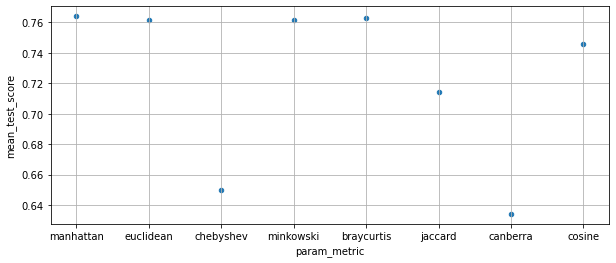

In [39]:
knn_metrics_pd.plot.scatter(x='param_metric',y='mean_test_score',figsize=(10,4), grid=True)  

#### Finding the best value of k (number of neighbours) for the k nn classifier.

In [40]:
parameters = {'n_neighbors':[2,4,8,16,32,64,128] }
knn_g2 = KNeighborsClassifier(metric='euclidean')
grid2 = GridSearchCV(knn_g2, parameters, cv = 8)
grid2.fit(visual_words_pyramid, train_labels)

GridSearchCV(cv=8, error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='euclidean',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=None,
             param_grid={'n_neighbors': [2, 4, 8, 16, 32, 64, 128]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [41]:
knn_neighbours_pd = pd.DataFrame.from_dict(grid2.cv_results_)
knn_neighbours_pd[['param_n_neighbors','mean_test_score','std_test_score','rank_test_score']]

param_n_neighbors  mean_test_score  std_test_score  rank_test_score
0                 2         0.687403        0.046448                7
1                 4         0.745348        0.040394                5
2                 8         0.769800        0.042271                1
3                16         0.768748        0.049537                2
4                32         0.765552        0.043043                3
5                64         0.756525        0.043304                4
6               128         0.740572        0.038471                6

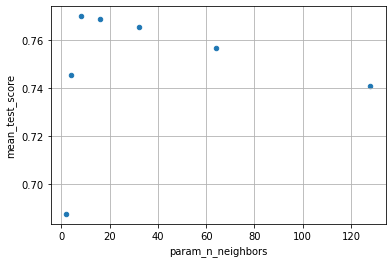

In [42]:
knn_neighbours_pd.plot.scatter(x='param_n_neighbors',y='mean_test_score', grid=True)  

#### Conclusions
- Regarding the distance metrics, we obtain the best results with Manhattan distance by a small margin. 
Most of the distances worked more or less similar except for Chebyshev, Jaccard and Canberra. 
Note that we can define the Minkowski distance as:

 $ {d} = (\sum \limits _{i=1} ^{n} |x_i - y_i|^p)^{1/p}$ 
 
    The p value in the minkowski formula can be manipulated to give us different distances like:
        - p = 1, when p is set to 1 we get Manhattan distance
        - p = 2, when p is set to 2 we get Euclidean distance 
The default p for Minkowski is 2, therefore makes sense that Euclidean and Minkowski return the same value. Manhattan is also based on minkowski, 
and by using a p=1 we penalize less the errors introduced by outliers.

- We decided to use Euclidean as the distance metric, as the results are really similar to those obtained with 
Manhattan and Braycurtis distances. Moreover, the standard deviation is lower (by a small margin, though), so 
the system is more consistent.

- Regarding the number of neighbours, we should chose it to be large enough so that the noise in the data is minimized, 
but small enough so that samples from other classes are not included. In this case, considering a number of neighbours 
of 8 seems to yield better results.

### 5.2 Logistic regression <a name="logreg"></a>

We have also built a logistic regression classifier and trained it with the codebook of descriptors we have generated.

To decide which is the best solver, we compute the accuracy (mean and standard deviation) with 8 (stratified) fold cross-validation.

In [43]:
parameters = {'solver':('newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga')}
logreg_g = LogisticRegression()
grid3 = GridSearchCV(logreg_g, parameters, cv=8)
grid3.fit(visual_words_pyramid, train_labels)

GridSearchCV(cv=8, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'solver': ('newton-cg', 'lbfgs', 'liblinear', 'sag',
                                    'saga')},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [79]:
log_solver_pd = pd.DataFrame.from_dict(grid3.cv_results_)
log_solver_pd[['param_solver','mean_test_score','std_test_score','rank_test_score']]

param_solver  mean_test_score  std_test_score  rank_test_score
0    newton-cg         0.808096        0.026054                4
1        lbfgs         0.810758        0.025275                3
2    liblinear         0.797990        0.025267                5
3          sag         0.818732        0.026158                2
4         saga         0.822983        0.028180                1

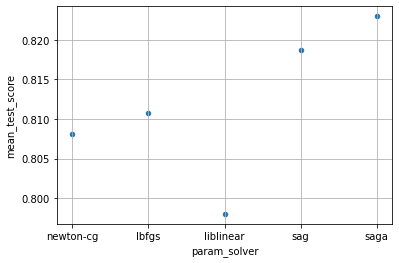

In [45]:
log_solver_pd.plot.scatter(x='param_solver',y='mean_test_score', grid=True)  

We used gridsearch for other function parameters: max_iter, C (inverse of regularization parameter) and random_state, but as the best results were obtained with the default parameters (max_iter = 100, C = 1 
and random_state = 0), we will be using them from now on, in addition to the saga solver.

#### Conclusions

- Logistic regression outperforms K Nearest Neighbours Classifier for each of the logreg solvers, so we can 
conclude that this classifier is better suited for our problem than the KNN one.
- We obtain the best results with Logistic Regression with 'saga' and 'sag' solver, with up to 0.82 of accuracy.

##### From now on, we'll use Dense SIFT with step size = 15, pyramid level = 1, codebook size = 128 and logistic regression with 'saga' solver.

## 6. Reducing dimensionality  <a name="pca"></a>

To decrease computational time, we can use some techniques such as PCA and LDA to reduce the feature space dimensionality 
projecting it to a lower dimensional space.

#### PCA

For PCA, we can set the parameter "n_components" to select the number of dimensions or the percentage of information
of the data to be kept after the dimensionality reduction. 

The parameter "n_components" represents a percentage if it's between 0 and 1 or a number of dimensions if it's > 1. For each of these cases, we used gridsearch to tune it.

In [46]:
pca = PCA(n_components=0.8, svd_solver='full') # if it's between 0 and 1 -> percentage
VWpca = pca.fit_transform(visual_words_pyramid)

classifier = LogisticRegression(solver = 'saga')
classifier.fit(VWpca, train_labels)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)

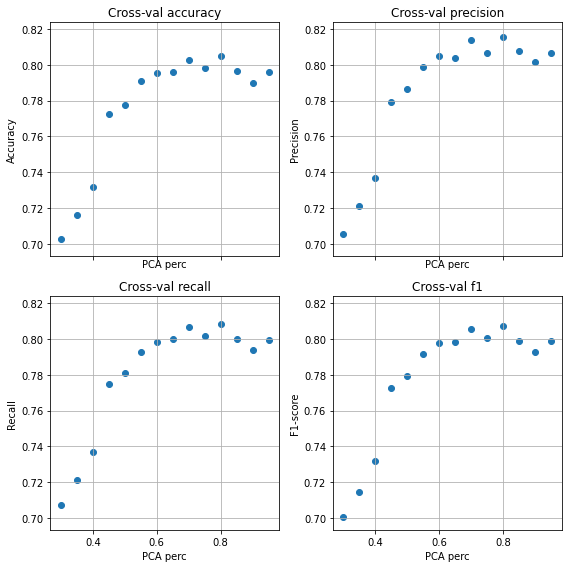

In [48]:
pca_perc_gridsearch = pd.read_csv('../../Optimize_params/single_params/pca_perc.csv')
plot_metrics(pca_perc_gridsearch, 'PCA perc')

In [49]:
pca = PCA(n_components=64, svd_solver='full') # if it's > 1 -> number of dimensions
VWpca = pca.fit_transform(visual_words_pyramid)

classifier = LogisticRegression(solver = 'saga')
classifier.fit(VWpca, train_labels)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)

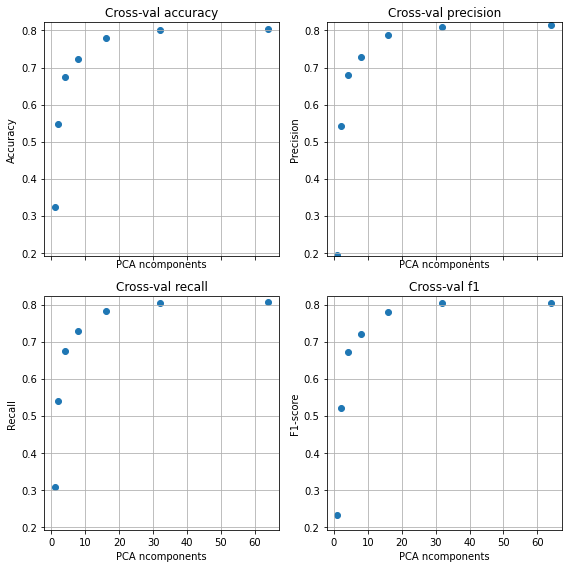

In [52]:
pca_dim_gridsearch = pd.read_csv('../../Optimize_params/single_params/pca_ncomponents.csv')
plot_metrics(pca_dim_gridsearch, 'PCA ncomponents')

#### LDA
To reduce the dimensionality using LDA, we need the number of components to be <= min(num_classes-1, nfeatures). 
LDA tries to find a decision boundary around each cluster of a class. It then projects the data points to new 
dimensions in a way that the clusters are as separate from each other as possible. Therefore, we have n-classes-1 
distances to optimize, and we can't have a bigger number of components.

We used gridsearch to tune the parameter "n_components".

In [53]:
lda = LinearDiscriminantAnalysis(n_components=7)
VWlda = lda.fit_transform(visual_words_pyramid,train_labels)

classifier = LogisticRegression(solver = 'saga')
classifier.fit(VWlda, train_labels) 

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)

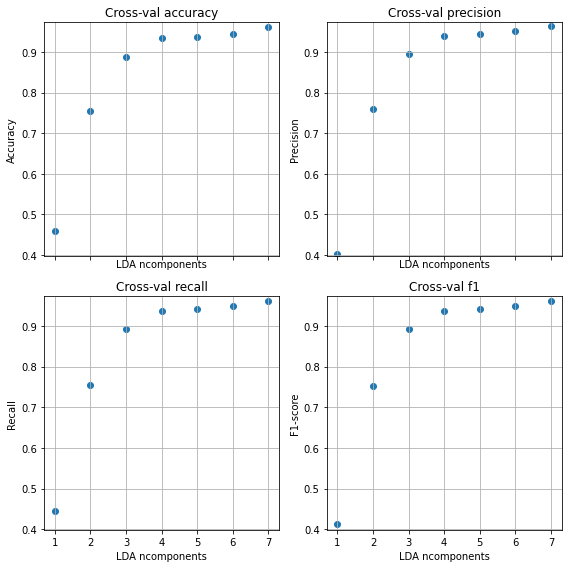

In [58]:
lda_gridsearch = pd.read_csv('../../Optimize_params/single_params/lda_ncomponents.csv')
plot_metrics(lda_gridsearch, 'LDA ncomponents')

## Conclusions

- Applying PCA does not increase the performance drastically because we already found the optimal number of features to use 
using our GridSearch. However, it speeds up the computation as the dimensionality is decreased, while mantaining a similar
performance.
- For LDA, with a ncomponents >= 3 the results are highly improved, as this technique is able to reduce the feature dimensionality while maximizing the separability between classes, which leads into a better performance. The bests results are obtained with ncomponents = 7 (= nclasses-1), because the information is more complete.

## 7. Cross-Validation <a name="cross_validation"></a>
Note that we have used already cross-validation on the gridsearch to obtain the best parameters. 
However, we will extract the cross-validation results for the best combination of descriptors, clustering and classifier.
That is: 
- Dense SIFT with step_size = 15
- Spatial pyramid level = 1
- Codebook with k = 128
- Logistic Regression with solver = saga
- LDA with 7 components

In [75]:
lda = LinearDiscriminantAnalysis(n_components=7)
VWlda = lda.fit_transform(visual_words_pyramid,train_labels)

classifier = LogisticRegression(solver='saga')
cv_scores = cross_validate(classifier, VWlda, 
                          train_labels,scoring = ['accuracy', 'precision_macro', 'recall_macro','f1_macro'], 
                          cv=8)

In [76]:
cross_validation_pd = pd.DataFrame.from_dict(cv_scores)
cross_validation_pd.round(3)

fit_time  score_time  test_accuracy  test_precision_macro  \
0     0.178       0.004          0.966                 0.971   
1     0.102       0.006          0.979                 0.979   
2     0.110       0.003          0.979                 0.981   
3     0.128       0.004          0.987                 0.988   
4     0.108       0.004          0.970                 0.972   
5     0.118       0.004          0.983                 0.985   
6     0.114       0.006          0.983                 0.985   
7     0.112       0.005          0.949                 0.951   

   test_recall_macro  test_f1_macro  
0              0.963          0.966  
1              0.981          0.980  
2              0.980          0.980  
3              0.988          0.988  
4              0.973          0.972  
5              0.985          0.985  
6              0.984          0.984  
7              0.950          0.950

In [77]:
print("%0.2f accuracy with a std dev of %0.2f" % (cv_scores['test_accuracy'].mean(), cv_scores['test_accuracy'].std()))
print("%0.2f precision with a std dev of %0.2f" % (cv_scores['test_precision_macro'].mean(), cv_scores['test_precision_macro'].std()))
print("%0.2f recall with a std dev of %0.2f" % (cv_scores['test_recall_macro'].mean(), cv_scores['test_recall_macro'].std()))
print("%0.2f F1-score with a std dev of %0.2f" % (cv_scores['test_f1_macro'].mean(), cv_scores['test_f1_macro'].std()))

0.97 accuracy with a std dev of 0.01
0.98 precision with a std dev of 0.01
0.98 recall with a std dev of 0.01
0.98 F1-score with a std dev of 0.01


#### Conclusions
* Within the different 8 folds, the system presents a low std dev of 0.01, which allows us to validate the consistency of our system.
* We obtain an accuracy of 0.97 and an average precision, recall and F1-score of 0.98, which are outstanding results.
* In addition, by using LDA, the execution is really fast (low score_time), as this technique allows reducing the feature dimensionality and thus the computational cost.

## 8. Test validation <a name="test_validation"></a>
Now that we have trained and cross-validated our system, we can analyze the results that we obtain with the test dataset.

In [80]:
visual_words_test=np.zeros((len(test_images_filenames),visual_words_pyramid.shape[1]),dtype=np.float32)
for i in range(len(test_images_filenames)):
    filename=test_images_filenames[i]
    ima=cv2.imread(filename)
    gray=cv2.cvtColor(ima,cv2.COLOR_BGR2GRAY)
    pyramid_des = spatial_pyramid(gray, SIFTdetector, level=1, dense=True, step_size=15)
    visual_words_test[i,:] = spatial_pyramid_histograms(pyramid_des, codebook, k=128)

In [90]:
lda = LinearDiscriminantAnalysis(n_components=7)
VWlda = lda.fit_transform(visual_words_pyramid,train_labels)

classifier = LogisticRegression(solver='saga')
classifier.fit(VWlda, train_labels)

vwtestlda = lda.transform(visual_words_test) 
test_lda_prediction = classifier.predict(vwtestlda)
test_lda_precision, test_lda_recall, test_lda_fscore, _ = precision_recall_fscore_support(test_labels, test_lda_prediction, average='macro')
test_lda_accuracy = classifier.score(vwtestlda, test_labels)

print("%0.2f accuracy" % (test_lda_accuracy))
print("%0.2f precision" % (test_lda_precision))
print("%0.2f recall" % (test_lda_recall))
print("%0.2f F1-score" % (test_lda_fscore))

0.78 accuracy
0.78 precision
0.78 recall
0.78 F1-score


#### Conclusions
* As observed, the performance of the classifier in the test dataset is acceptable, but much worse than with the training dataset. One of the reasons can be an overfitting of the classifier, which means that it's not generalizing well to unseen datasets. With a larger training dataset or other classifier/techniques, we expect to improve the results. 

## 9. Visualization of Results <a name="visualization"></a>

### 9.1 ROC Curve <a name="roc_curve"></a>
We will plot the ROC curve to visually analyze the behaviour of our classifier when treating it as a one-vs-all binary classifier.

In [91]:
# first we need to binarize the labels
y_train = LabelBinarizer().fit_transform(train_labels)
y_test = LabelBinarizer().fit_transform(test_labels)
n_classes = y_train.shape[1]
print(y_train)

[[1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 1]
 [0 0 0 ... 0 0 1]
 [0 0 0 ... 0 0 1]]


In [93]:
# classifier
clf = OneVsRestClassifier(LogisticRegression(solver='saga'))
clf.fit(VWlda, y_train)
y_score = clf.predict_proba(vwtestlda)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

In [94]:
# Then interpolate all ROC curves 
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

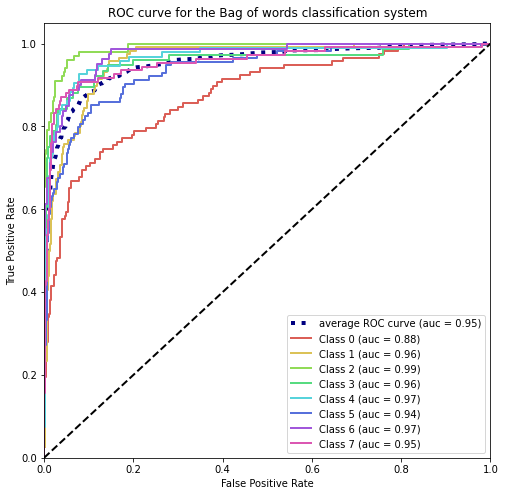

In [95]:
# Plot all ROC curves
plt.figure(figsize=(8,8))
lw = 2
plt.plot(fpr["macro"], tpr["macro"],
         label='average ROC curve (auc = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

palette = sns.color_palette("hls", 8)
colors = cycle(palette)
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='Class {0} (auc = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve for the Bag of words classification system')
plt.legend(loc="lower right")
plt.show()

In [96]:
np.unique(test_labels)

array(['Opencountry', 'coast', 'forest', 'highway', 'inside_city',
       'mountain', 'street', 'tallbuilding'], dtype='<U12')

#### Conclusions
* We can observe that the class that is best classified is class 2, that corresponds to forests. Having a look at the images visualized on [1. Dataset](#dataset), we can see how the forest dataset is mainly formed by trees, 
that have a similar pattern of textures and colors, doesn't matter how the forest is.
* On the other hand, the class that is worst classified is class 0, which is Opencountry. The opencountry dataset shows
different kinds of landscapes, from desert to mountains, in some cases with a big part of the image being the blue sky and others
showing just a bit of clouds. 

### Visualizing matches and missclassifications

Finally, we can see the exact predictions that went right and wrong using the following functions.

In [97]:
def visualize_wrong_predictions(image_filenames, labels, predictions, samples_per_class=5):
    print(f'Number of samples: {len(predictions)}')
    print(f'Number of wrongly classified samples: {sum(predictions!=labels)}')
    
    # get unique classses
    classes = np.unique(np.array(labels))
    num_classes = len(classes)
    #set size for plot
    plt.figure(figsize=(24,16))
    
    def get_index_fp(idxs):
        items = []
        for idx in idxs:
            if predictions[idx] != labels[idx]:
                items.append(idx)
        return items
    
    for y, cls in enumerate(classes):
        idxs_all = np.flatnonzero(np.array(labels) == cls)
        idxs_fp = get_index_fp(idxs_all)
        idxs = np.random.choice(idxs_fp, samples_per_class, replace=False)
        class_accuracy = 100*(1 - (len(idxs_fp)/len(idxs_all)))
        for i, idx in enumerate(idxs):
            plt_idx = i * num_classes + y + 1
            plt.subplot(samples_per_class, num_classes, plt_idx)
            plt.imshow(Image.open(image_filenames[idx]))
            plt.axis('off')
            if i == 0:
                plt.title(f'{cls} \n ClassAccuracy: {class_accuracy:.2f}  \n GT: {test_labels[idx]},\n Pred: {predictions[idx]}')
            else:
                plt.title(f'GT: {test_labels[idx]},\n Pred: {predictions[idx]}')
    plt.show()


def visualize_correct_predictions(image_filenames, labels, predictions, samples_per_class=5):
    print(f'Number of samples: {len(predictions)}')
    print(f'Number of correctly classified samples: {sum(predictions==labels)}')
    
    # get unique classses
    classes = np.unique(np.array(labels))
    num_classes = len(classes)
    #set size for plot
    plt.figure(figsize=(24,16))
    
    def get_index_tp(idxs):
        items = []
        for idx in idxs:
            if predictions[idx] == labels[idx]:
                items.append(idx)
        return items
    
    for y, cls in enumerate(classes):
        idxs_all = np.flatnonzero(np.array(labels) == cls)
        idxs_tp = get_index_tp(idxs_all)
        idxs = np.random.choice(idxs_tp, samples_per_class, replace=False)
        class_accuracy = 100*(len(idxs_tp)/len(idxs_all))
        for i, idx in enumerate(idxs):
            plt_idx = i * num_classes + y + 1
            plt.subplot(samples_per_class, num_classes, plt_idx)
            plt.imshow(Image.open(image_filenames[idx]))
            plt.axis('off')
            if i == 0:
                plt.title(f'ClassAccuracy: {class_accuracy:.2f}  \n GT: {test_labels[idx]},\n Pred: {predictions[idx]}')
            else:
                plt.title(f'GT: {test_labels[idx]},\n Pred: {predictions[idx]}')
    plt.show()

Number of samples: 807
Number of wrongly classified samples: 181


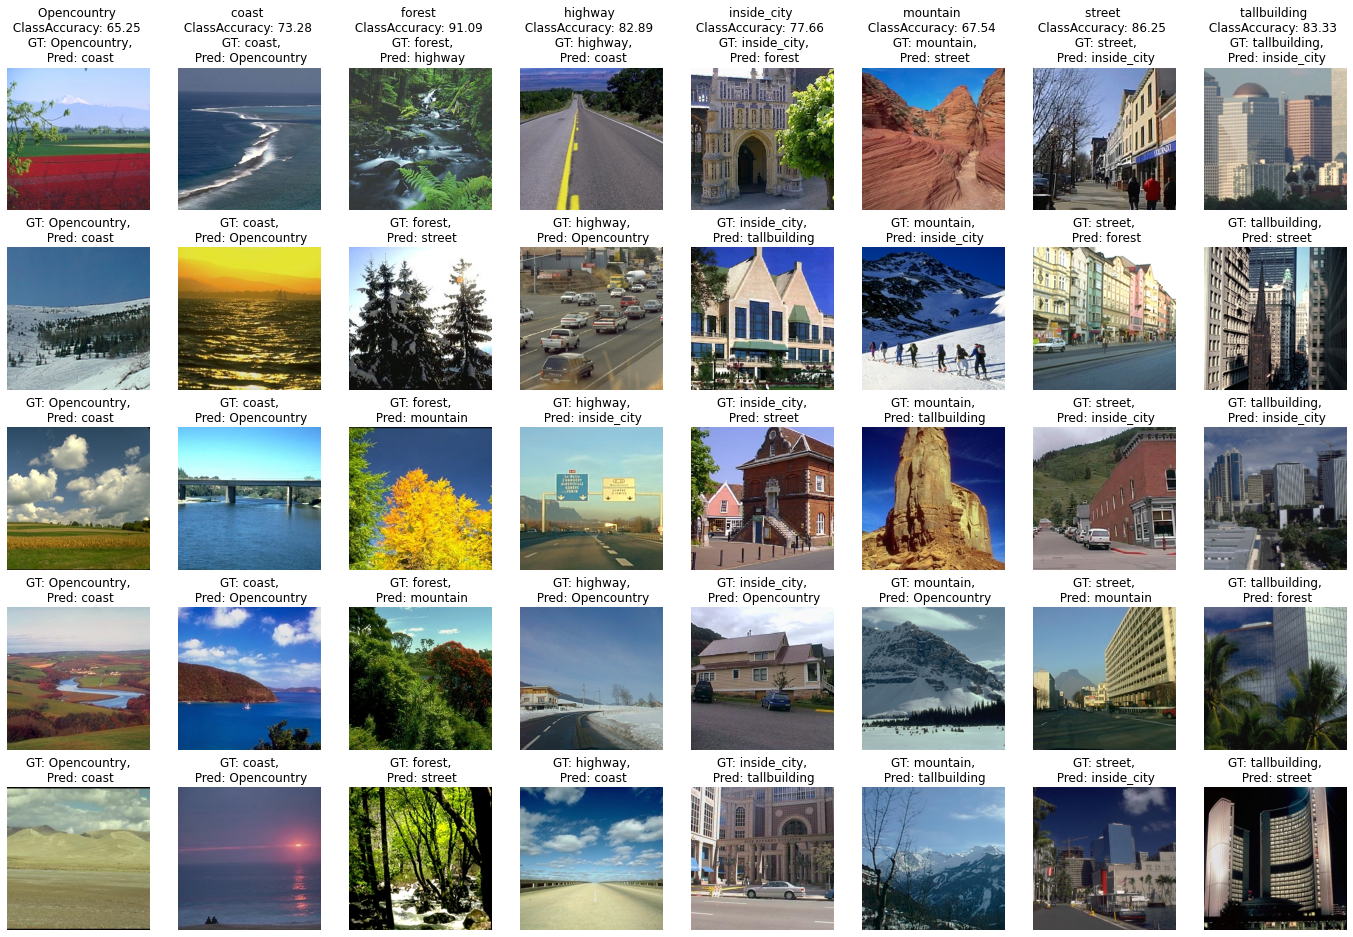

In [98]:
visualize_wrong_predictions(test_images_filenames, test_labels, test_lda_prediction)

Number of samples: 807
Number of correctly classified samples: 626


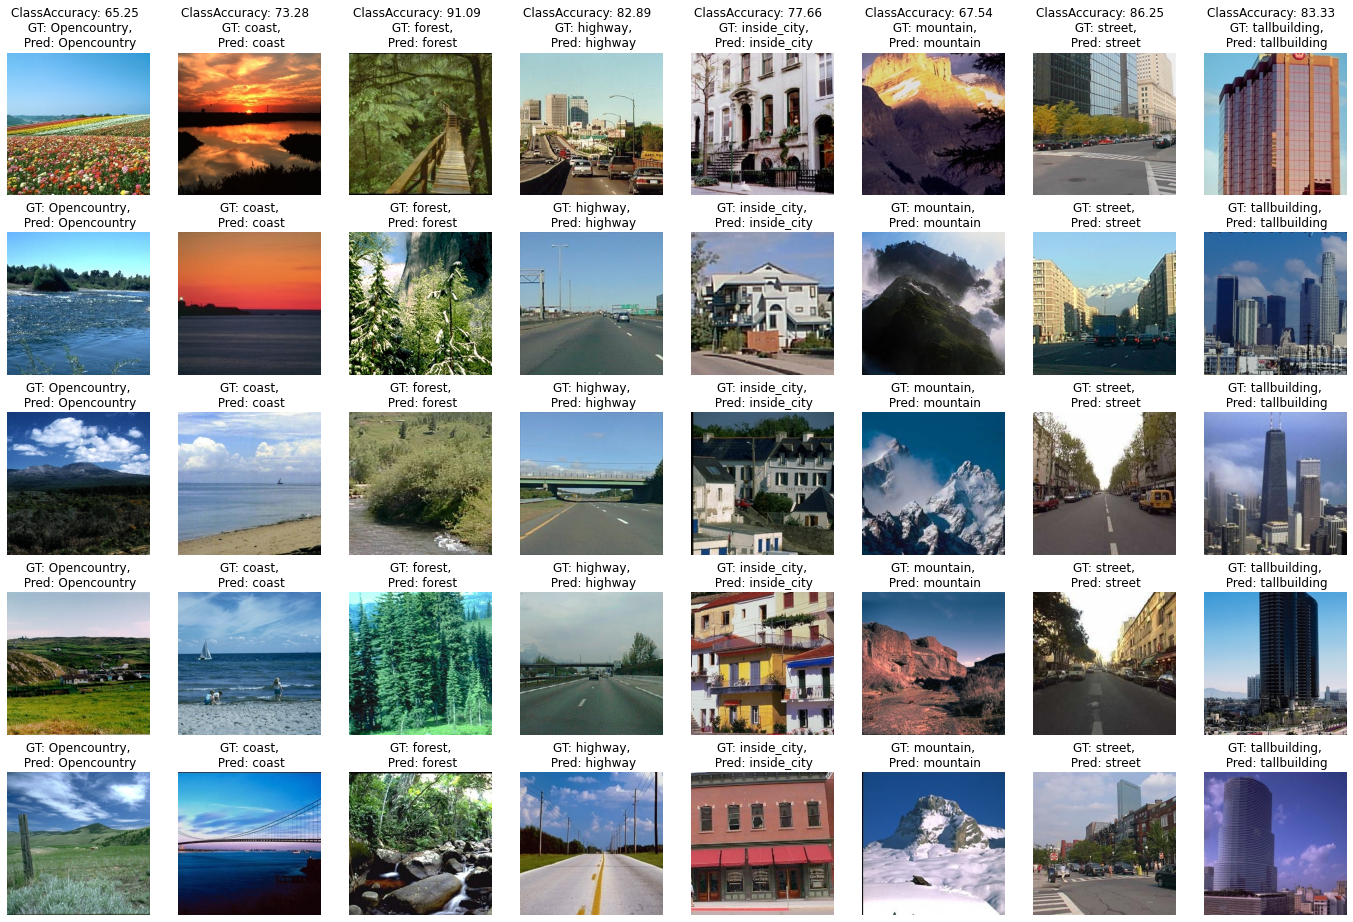

In [99]:
visualize_correct_predictions(test_images_filenames, test_labels, test_lda_prediction)

## Conclusion

The classes which are difficult to predict for the model are also difficult to predict for humans. As we can see in most of the wrongly 
classified examples, they are wrong because they look very similar to the other classes visually, so it is not a surprise that the model 
has a difficulty in predicting them. The used dataset is tricky as well, as some classes contain other classes as elements. For example, an image of the class inside_city,
might include the view of a street or tall buildings, which are classes themselves.